In [1]:
#Data Understanding
import numpy as np 
import pandas as pd 
import seaborn as sns
import warnings
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import skew
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from scipy import stats
import statsmodels.stats.multitest as multi

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
warnings.filterwarnings("ignore")

In [5]:
df_calendar = pd.read_csv("calendar.csv")
df_listings = pd.read_csv("listings.csv")
df_reviews = pd.read_csv("reviews.csv")

for data in [df_calendar,df_listings,df_reviews]:
    display(data.head())
    print(data.shape)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


(1393570, 4)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,...,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,...,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,...,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,https://a2.muscache.com/ac/pictures/b4324e0f-a...,NaN,16708587,https://www.airbnb.com/users/show/16708587,Jill,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,...,t,1,6,17,220,2016-01-04,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/ac/pictures/94146944/6...,NaN,9851441,https://www.airbnb.com/users/show/9851441,Emily,2013-11-06,"Seattle, Washington, United States",NaN,NaN,NaN,NaN,...,t,0,0,0,143,2016-01-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,NaN,NaN,https://a1.muscache.com/a

(3818, 92)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


(84849, 6)


In [ ]:
#Data Preparation

In [6]:
# Retrieve the creation date of the dataframe for feature engineering
df_listing_last_scraped = pd.Timestamp(df_listings.last_scraped[0])

# Drop duplicate columns
df_listings = df_listings.T.drop_duplicates().T

# Drop columns with full NA
df_listings.dropna(axis=1,how="all",inplace=True)

# Drop columns with only one unique value
df_listings.drop([c for c in df_listings.columns if df_listings[c].nunique()==1],axis=1,inplace=True)

# Drop columns representing url
df_listings.drop(df_listings.columns[df_listings.columns.str.contains("url")],axis=1,inplace=True)

# Reformat the money related columns
df_listings.price = df_listings.price.str.replace(r"$","").str.replace(",","").astype("float32")
df_listings.weekly_price = df_listings.weekly_price.str.replace(r"$","").str.replace(",","").astype("float32")
df_listings.monthly_price = df_listings.monthly_price.str.replace(r"$","").str.replace(",","").astype("float32")
df_listings.security_deposit = df_listings.security_deposit.str.replace(r"$","").str.replace(",","").astype("float32")
df_listings.cleaning_fee = df_listings.cleaning_fee.str.replace(r"$","").str.replace(",","").astype("float32")
df_listings.extra_people = df_listings.extra_people.str.replace(r"$","").str.replace(",","").astype("float32")

# Transform the date related columns
df_listings['host_since_deltaDays'] = (pd.to_datetime(df_listing_last_scraped)-pd.to_datetime(df_listings.host_since)).dt.days
df_listings['last_review_deltaDays'] = (pd.to_datetime(df_listing_last_scraped)-pd.to_datetime(df_listings.last_review)).dt.days
df_listings['first_review_deltaDays'] = (pd.to_datetime(df_listing_last_scraped)-pd.to_datetime(df_listings.first_review)).dt.days

# Reformat other features
df_listings['host_response_time'] = df_listings.host_response_time.map({"within an hour":1,"within a few hours":12,\
                                                                        "within a day":24,"a few days or more":48})
df_listings.host_response_rate = df_listings.host_response_rate.str.replace("%","").astype("float32")
df_listings['cancellation_policy'] = df_listings['cancellation_policy'].map({'strict':0,'moderate':1,'flexible':2})

# Create a feature count the number of host verification methods
host_verifications = np.unique(np.concatenate(df_listings.host_verifications.map(lambda x:x[1:-1].replace("'","").split(", "))))[1:]
matrix_verifications=[[veri in row for row in df_listings.host_verifications.map(lambda x:x[1:-1].replace("'","").split(", ")) ] for veri in host_verifications]
df_listings['host_verificationCount'] = pd.DataFrame(matrix_verifications,index=host_verifications).T.sum(1)

In [7]:

features_host = ['host_is_superhost','host_about','host_response_time','host_response_rate', 'host_listings_count',
                 'host_verificationCount','host_has_profile_pic','host_identity_verified','host_since_deltaDays',\
                 'calculated_host_listings_count']

features_property = ['summary','space','description','neighborhood_overview','notes','transit',
                     'street','neighbourhood','zipcode','latitude','longitude','is_location_exact',
                     'property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type',
                     'amenities','square_feet','price','weekly_price','security_deposit','cleaning_fee',
                     'guests_included','extra_people','minimum_nights','maximum_nights']

features_traveler = ['number_of_reviews','last_review_deltaDays','first_review_deltaDays','review_scores_rating',
                     'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                     'review_scores_location','review_scores_value','instant_bookable','cancellation_policy',\
                     'require_guest_profile_picture','require_guest_phone_verification','reviews_per_month']

features = features_host + features_property + features_traveler
df_listings_filtered = df_listings[features]

In [8]:
numeric_feature = ['host_listings_count','calculated_host_listings_count','latitude','longitude','accommodates','bathrooms',\
                   'bedrooms','beds','guests_included','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating',\
                   'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',\
                   'review_scores_location','review_scores_value', 'review_scores_rating' ,'review_scores_accuracy',\
                   'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location',\
                   'review_scores_value' ,'reviews_per_month'] 

bool_feature = ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact','instant_bookable',\
                'require_guest_phone_verification','require_guest_profile_picture']

# Transform the bool features
for bool_f in bool_feature:
  df_listings_filtered[bool_f] = df_listings_filtered[bool_f].map({'t':1,'f':0}).astype('bool')

# Transform the numerical features
for num_f in numeric_feature:
    df_listings_filtered[num_f] = df_listings_filtered[num_f].astype("float32")

In [9]:
# Fix the weird zipcode value
df_listings_filtered.zipcode[df_listings_filtered.zipcode=="99\n98122"] = 98122
# Drop column square_feet for containing too many NA values (97.5%)
df_listings_filtered.square_feet.isna().mean()
df_listings_filtered.drop("square_feet",axis=1,inplace=True)

In [10]:
# Transform the amenities feature into a one-hot encoding matrix
unqiue_amenities = np.unique(np.concatenate(df_listings_filtered.amenities.str[1:-1].str.replace('"','')\
                                            .str.split(",")))[1:]
matrix_amenities=[[amen in row for row in df_listings_filtered.amenities.str[1:-1].str.replace('"','').\
                   str.split(",") ] for amen in unqiue_amenities]
df_amenities = pd.DataFrame(matrix_amenities,index=unqiue_amenities).T

# Drop amenities features appaer in less than 5% of samples to avoid overfitting
df_amenities.drop(df_amenities.columns.values[np.where(df_amenities.mean()<0.05)],axis=1,inplace=True)
df_listings_filtered_amenities = pd.concat([df_listings_filtered,df_amenities],axis=1)

In [11]:
# Missing Value Imputation

In [12]:
print(df_listings_filtered_amenities.isna().mean().sort_values(ascending=False).head(35))

security_deposit               0.511262
weekly_price                   0.473808
notes                          0.420639
neighborhood_overview          0.270299
cleaning_fee                   0.269775
transit                        0.244631
host_about                     0.224987
review_scores_checkin          0.172342
review_scores_accuracy         0.172342
review_scores_value            0.171818
review_scores_location         0.171556
review_scores_cleanliness      0.171032
review_scores_communication    0.170508
review_scores_rating           0.169460
first_review_deltaDays         0.164222
last_review_deltaDays          0.164222
reviews_per_month              0.164222
space                          0.149031
host_response_time             0.136983
host_response_rate             0.136983
neighbourhood                  0.108958
summary                        0.046359
bathrooms                      0.004191
zipcode                        0.001833
bedrooms                       0.001572


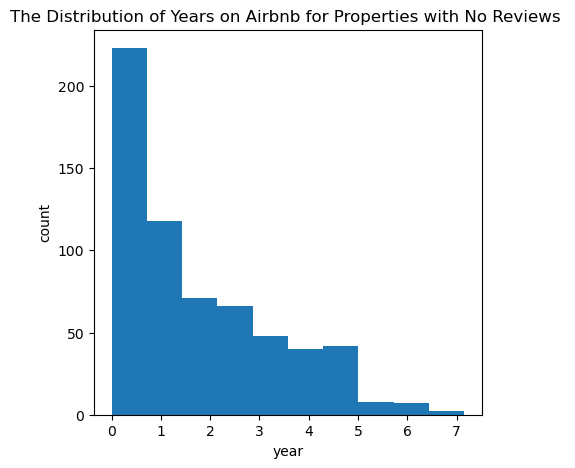

In [13]:
f, axs = plt.subplots(1,1,figsize=(5,5))
(df_listings_filtered_amenities.query("number_of_reviews==0").host_since_deltaDays/365).plot(kind="hist")
ax = plt.gca()
ax.set_title("The Distribution of Years on Airbnb for Properties with No Reviews ")
ax.set_xlabel("year");
ax.set_ylabel("count");
f.show()

In [14]:
# Drop samples with zero reviews
# We see that the majority of missing values gone with these properties
df_listings_filtered_amenities = df_listings_filtered_amenities.query('number_of_reviews>0')
print(df_listings_filtered_amenities.isna().mean().sort_values(ascending=False).head(35))


security_deposit               0.493576
weekly_price                   0.435914
notes                          0.376371
cleaning_fee                   0.240677
neighborhood_overview          0.233783
transit                        0.204951
host_about                     0.182701
space                          0.104356
host_response_time             0.100282
host_response_rate             0.100282
neighbourhood                  0.096835
summary                        0.052648
review_scores_accuracy         0.009715
review_scores_checkin          0.009715
review_scores_value            0.009088
review_scores_location         0.008775
review_scores_cleanliness      0.008148
review_scores_communication    0.007521
review_scores_rating           0.006268
bathrooms                      0.003761
zipcode                        0.001880
bedrooms                       0.001880
Fire Extinguisher              0.000000
Cable TV                       0.000000
Carbon Monoxide Detector       0.000000


In [15]:
df_listings_filtered_amenities_cleaned = df_listings_filtered_amenities.copy()

# Fill NA for numeric features
df_listings_filtered_amenities_cleaned.zipcode = df_listings_filtered_amenities_cleaned.zipcode.fillna(
                                                df_listings_filtered_amenities_cleaned.zipcode.mode()[0])
feature_fillna_median = ['host_response_time','host_response_rate','security_deposit','cleaning_fee','weekly_price','bedrooms',
                         'bathrooms','review_scores_rating','review_scores_communication','review_scores_cleanliness','review_scores_location',
                         'review_scores_value','review_scores_accuracy','review_scores_checkin']
df_listings_filtered_amenities_cleaned[feature_fillna_median] = df_listings_filtered_amenities_cleaned[feature_fillna_median].fillna(
                                                                df_listings_filtered_amenities_cleaned[feature_fillna_median].median())

# Fill NA for object features
feature_fillna_empty =  ['summary','neighbourhood','space','host_about','transit','neighborhood_overview','notes']
df_listings_filtered_amenities_cleaned[feature_fillna_empty] = df_listings_filtered_amenities_cleaned[feature_fillna_empty].fillna('')

# Numerical features
df_num = df_listings_filtered_amenities_cleaned.select_dtypes(exclude='object')
# One hot encoding categorical features
df_cat = pd.get_dummies(df_listings_filtered_amenities_cleaned.select_dtypes(include='object')[['property_type','room_type', 'bed_type']])
# Drop one hot categorical feature columns appearing less then 5% of samples
catFeatureToDrop = df_cat.columns.where(df_cat.mean()<0.05).dropna()
df_cat.drop(catFeatureToDrop,axis=1,inplace=True)
df_cat = df_cat.astype("bool")
df_total = pd.concat([df_num,df_cat],axis=1)

In [16]:
#Two Sample Independent T-Test

In [17]:
# Helper function for two independent sample t-test
def ttest(df,group_feature, test_feature):
    flag0 = df[group_feature]==False
    flag1 = ~flag0
    vector_0 = df.loc[flag0,test_feature]
    vector_1 = df.loc[flag1,test_feature]
    statistic, pvalue = stats.ttest_ind(vector_1, vector_0)
    return [statistic,pvalue,test_feature]    

In [18]:
# T-test
ttest_result = []
for col in df_total.columns:
    if col=="host_is_superhost":
        continue
    else:
        ttest_result.append(ttest(df_total,"host_is_superhost",col))

# Display the t-test result
ttest_result = pd.DataFrame(ttest_result,columns=['statistics','pvalue','feature'])
# P-value adjustment
multitest_result = multi.multipletests(ttest_result.pvalue,method="bonferroni")
ttest_result['significant'],ttest_result['adjust_pvalue']=multitest_result[0],multitest_result[1]
ttest_result.sort_values(['significant','adjust_pvalue'],ascending=[False,True]).style.bar(subset=['statistics'], 
                                                                     align='zero', color=['#d65f5f', '#5fba7d'])

,statistics,pvalue,feature,significant,adjust_pvalue
37,15.911607,0.000000,reviews_per_month,True,0.000000
26,13.952008,0.000000,review_scores_rating,True,0.000000
23,13.477553,0.000000,number_of_reviews,True,0.000000
28,13.172330,0.000000,review_scores_cleanliness,True,0.000000
32,12.538164,0.000000,review_scores_value,True,0.000000
27,12.240080,0.000000,review_scores_accuracy,True,0.000000
29,9.388841,0.000000,review_scores_checkin,True,0.000000
30,9.174692,0.000000,review_scores_communication,True,0.000000
66,8.128337,0.000000,Shampoo,True,0.000000
1,7.705804,0.000000,host_response_rate,True,0.000000


In [ ]:
#RESULT

In [19]:
# About 43% of the significant features are amenities.
ttest_result.feature[ttest_result.significant==True].isin(unqiue_amenities).sum()/np.sum(ttest_result.significant==True)

0.42857142857142855

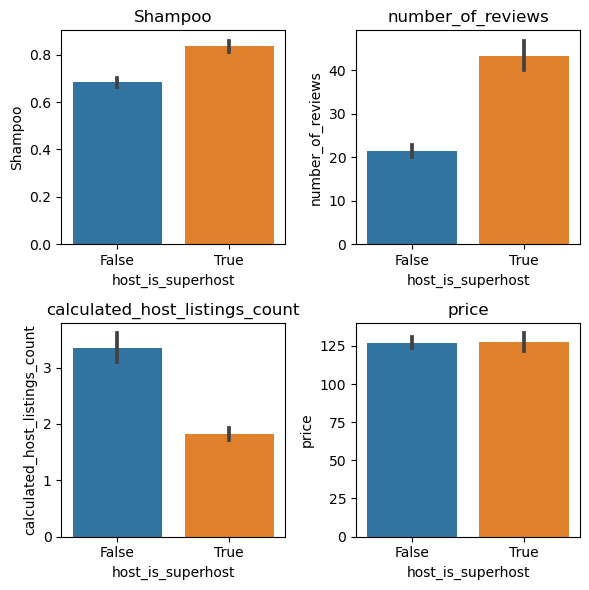

In [20]:
matplotlib.rcParams['figure.figsize'] = (6,6)
plt.subplot(221)
sns.barplot(data=df_total,y="Shampoo",x="host_is_superhost")
plt.title("Shampoo")
plt.subplot(222)
sns.barplot(data=df_total,y="number_of_reviews",x="host_is_superhost")
plt.title("number_of_reviews")
plt.subplot(223)
sns.barplot(data=df_total,y="calculated_host_listings_count",x="host_is_superhost")
plt.title("calculated_host_listings_count")
plt.subplot(224)
sns.barplot(data=df_total,y="price",x="host_is_superhost")
plt.title("price")
plt.tight_layout()


In [ ]:
#DATA MODELING

In [21]:
# Create the metric and named it "performance"
df_total['performance'] = df_total.reviews_per_month * df_num.review_scores_rating
# Draw host and review related features
featureToDrop = [f for f in df_total.columns.values if "review" in f or 'host' in f]
featureToDrop

['host_is_superhost',
 'host_response_time',
 'host_response_rate',
 'host_listings_count',
 'host_verificationCount',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_since_deltaDays',
 'calculated_host_listings_count',
 'number_of_reviews',
 'last_review_deltaDays',
 'first_review_deltaDays',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

In [22]:
X = df_total.drop(featureToDrop+['performance'],axis=1)
y = df_total.performance
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 10,100],scoring='r2').fit(X, y)
print("r2 score:{:.3f}".format(clf.score(X,y)))

r2 score:0.254


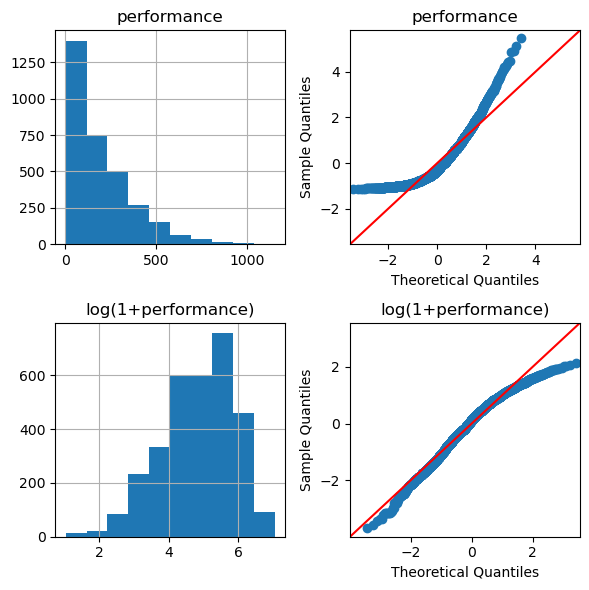

In [23]:
matplotlib.rcParams['figure.figsize'] = (6,6)
fig = plt.figure()

performance = df_total['performance']
log_performance = np.log1p(performance)
# histogram of performance 
ax = fig.add_subplot(2, 2, 1)
performance.hist(ax=ax)
plt.title("performance")

# qq-plot of performance
ax = fig.add_subplot(2, 2, 2)
sm.qqplot((performance-performance.mean())/performance.std(),line='45',ax=ax)
plt.title("performance")

# histogram of log transformed performance
ax = fig.add_subplot(2, 2, 3)
log_performance.hist(ax=ax)
plt.title("log(1+performance)")

# qqplot of log transformed performance
ax = fig.add_subplot(2, 2, 4)
sm.qqplot((log_performance-log_performance.mean())/log_performance.std(),line='45',ax=ax)
plt.title("log(1+performance)")
plt.tight_layout()


In [24]:
# Choose numeric features
num_feature = df_total.select_dtypes(include="number").dtypes.index.values

# Compute the sknewness, log transform features with abs(skewness)>0.75
skewed_feats = df_total[num_feature].apply(lambda x:x.skew())
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75]
skewed_feats = skewed_feats.index
# Helper function transforming features containing negative values 
# to features only containing nonnegative values
def moveToNonNegative(series):
  if series.min()<0:
    series = series-series.min()
  return series 

df_total[skewed_feats] = df_total[skewed_feats].apply(moveToNonNegative)
df_total[skewed_feats] = np.log1p(df_total[skewed_feats])

In [25]:
X = df_total.drop(featureToDrop+['performance'],axis=1)
y = df_total.performance
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 10,100],scoring='r2').fit(X, y)
print("r2 score:{:.3f}".format(clf.score(X,y)))

r2 score:0.318


In [ ]:
#RESULT

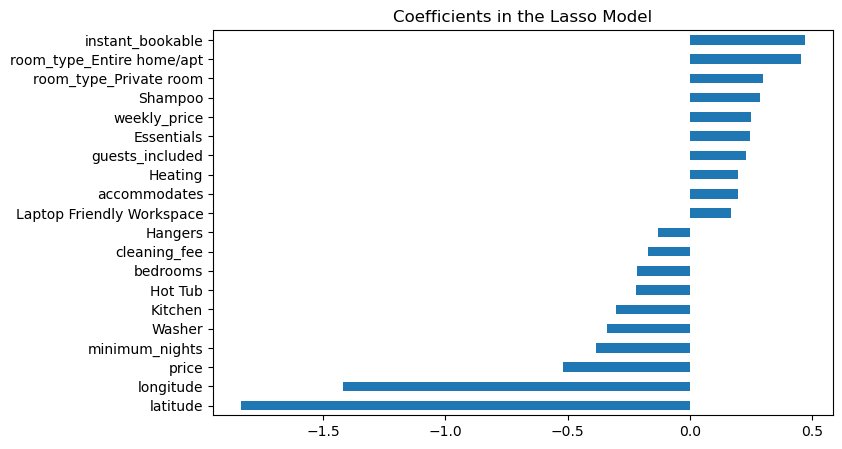

In [26]:
coef = pd.Series(clf.coef_, index = X.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [ ]:
#Time Series Data Wrangling and Visualization

In [27]:
# Extract year and month from date feature
df_reviews.date= pd.to_datetime(df_reviews.date)
df_reviews['year'] = df_reviews.date.dt.year
df_reviews['month'] = df_reviews.date.dt.month
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,year,month
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,2015,7
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,2015,7
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",2015,7
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,2015,8
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,2015,8


In [28]:
review_count = df_reviews.groupby(['year','month'])['comments'].size().reset_index()
# We drop 2009 and 2016 here as they don't contains data for full 12 months
review_count = review_count.loc[(review_count.year<2016) & (review_count.year>2009),:]
# I use log transform here to better observe the seasonal trend between different years
review_count_log = review_count.copy()
review_count_log.comments = np.log(review_count_log.comments)

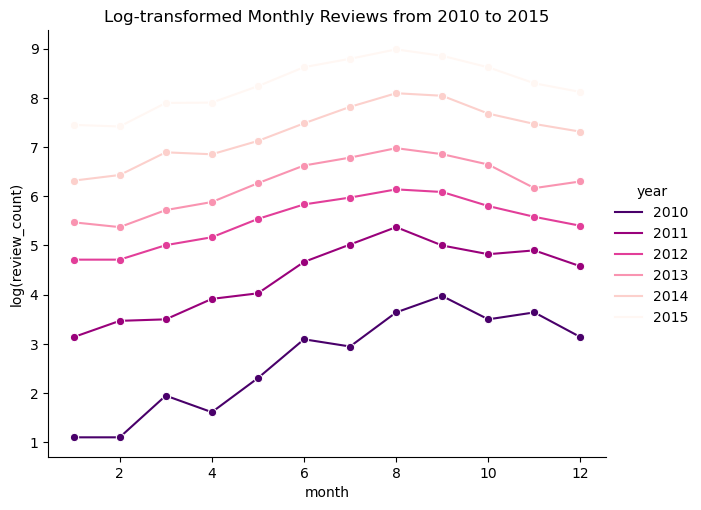

In [29]:
sns.relplot(data=review_count_log,x='month',hue='year',y='comments',marker='o',kind='line',palette="RdPu_r",aspect=10/8)
ax = plt.gca()
ax.set_ylabel("log(review_count)")
ax.set_title("Log-transformed Monthly Reviews from 2010 to 2015")
plt.show()

In [30]:
review_count_pivot = review_count.pivot(index='month',columns='year',values='comments').T

# YoY growth rate per month
review_YoY_perMonth = review_count_pivot.diff()/review_count_pivot.shift()
review_YoY_perMonth = review_YoY_perMonth.dropna()
review_YoY_perMonth = review_YoY_perMonth.stack().reset_index().rename(columns={0:'comments'})

# YoY growh rate per year
review_YoY_perYear = review_count_pivot.sum(axis=1).diff() / review_count_pivot.sum(axis=1).shift()
review_YoY_perYear = review_YoY_perYear.dropna()
review_YoY_perYear = review_YoY_perYear.reset_index().rename(columns={0:'comments'})

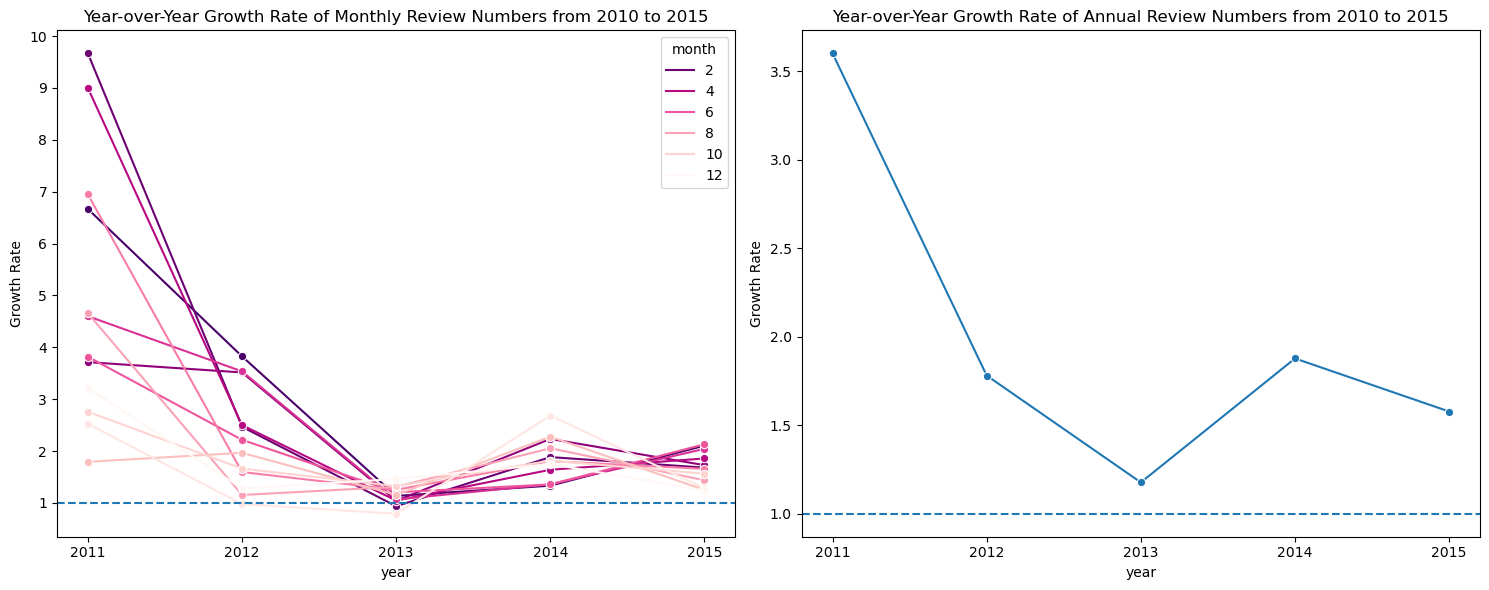

In [31]:
f, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(data=review_YoY_perMonth,x='year',hue='month',y='comments',marker='o',palette="RdPu_r",ax=axs[0])
ax = axs[0]
ax.axhline(1, ls='--')
ax.set_xticks([2011,2012,2013,2014,2015])
ax.set_yticks([1,2,3,4,5,6,7,8,9,10])
ax.set_ylabel("Growth Rate")
ax.set_title("Year-over-Year Growth Rate of Monthly Review Numbers from 2010 to 2015")
sns.lineplot(data=review_YoY_perYear,x='year',y='comments',marker='o',palette="RdPu_r",ax=axs[1])
ax = axs[1]
ax.axhline(1, ls='--')
ax.set_xticks([2011,2012,2013,2014,2015])
ax.set_ylabel("Growth Rate")
ax.set_title("Year-over-Year Growth Rate of Annual Review Numbers from 2010 to 2015")
f.tight_layout()

# CONCLUSION

As a traveler, it is advisable to prioritize booking with a Superhost, as they have a proven track record of providing exceptional hospitality and meeting guests' expectations, without overcharging
As an investor, it is recommended to avoid seeking properties in the northeastern area of Seattle. Additionally, it is advisable to rent out the property as an entire apartment or private rooms rather than a shared room.
Airbnb is steadily growing in Seattle throught out all these years. It seems like the growth rate became relatively stable and reach a plateu after 2013
The period of transition between summer and fall, typically occurring in late August and September, is widely considered the best time to visit Seattle due to its mild weather, pleasant outdoor activities, and seasonal events. On the other hand, the winter season in Seattle should generally be avoided due to the colder weather